In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import model.util as model_util
import model.binary_models as binary_models
import model.profile_models as profile_models
import feature.util as feature_util
import feature.make_binary_dataset as make_binary_dataset
import feature.make_profile_dataset as make_profile_dataset
import plot.viz_sequence as viz_sequence
import pandas as pd
import numpy as np
import torch
import tqdm
import matplotlib.pyplot as plt
import plotting.plots as plots
import json
import sknetwork as skn

### Define paths for the model and data of interest

In [3]:
# Define the paths to the files and model, and some constants
files_spec_path = "/users/amtseng/att_priors/data/processed/ENCODE/profile/config/SPI1/SPI1_training_paths.json"
model_path = "/users/amtseng/att_priors/models/trained_models/profile_models/SPI1_prior_attinflate/6/model_ckpt_epoch_10.pt"

reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
input_length = 1346
profile_length = 1000
num_tasks = 4
att_prior_pos_limit = 160

In [4]:
# Extract the file specs
with open(files_spec_path, "r") as f:
    files_spec = json.load(f)
peaks_bed = files_spec["val_peak_beds"][0]  # First peaks BED, arbitrarily
profile_hdf5 = files_spec["profile_hdf5"]

In [5]:
# Import the model
model = model_util.restore_model(profile_models.ProfileTFBindingPredictor, model_path)
model.eval()
torch.set_grad_enabled(True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device) 

### Data preparation
Use classes from `make_profile_dataset` to prepare positive and negative inputs.

In [6]:
# Maps coordinates to 1-hot encoded sequence
coords_to_seq = feature_util.CoordsToSeq(reference_fasta, center_size_to_use=input_length)

# Maps coordinates to profiles
coords_to_vals = make_profile_dataset.CoordsToVals(profile_hdf5, profile_length)

# Maps many coordinates to inputs sequences and profiles for the network
def coords_to_network_inputs(coords):
    input_seq = coords_to_seq(coords)
    profs = coords_to_vals(coords)
    return input_seq, np.swapaxes(profs, 1, 2)

In [7]:
# Import set of positive peaks
pos_coords_table = pd.read_csv(peaks_bed, sep="\t", header=None, compression="gzip")

### Predicting outputs

In [8]:
def predict_coords(coords):
    """
    Fetches the necessary data from the given coordinate and runs it through the
    network. Returns the network predictions, the true values from the dataset, and
    the input gradients. The returned profiles are in terms of raw counts, and the
    returned counts are also raw. Returned values are all NumPy arrays.
    """
    input_seqs, profiles = coords_to_network_inputs(coords)
    
    input_seqs = model_util.place_tensor(torch.tensor(input_seqs)).float()
    profiles = model_util.place_tensor(torch.tensor(profiles)).float()

    true_profs = profiles[:, :num_tasks, :, :]
    cont_profs = profiles[:, num_tasks:, :, :]

    model.zero_grad()
    
    # Run through the model
    input_seqs.requires_grad = True  # Set gradient required
    logit_pred_profs, log_pred_counts = model(input_seqs, cont_profs)
    
    # Compute input gradients
    input_grads, = torch.autograd.grad(
        logit_pred_profs, input_seqs,
        grad_outputs=model_util.place_tensor(torch.ones(logit_pred_profs.size())),
        retain_graph=True, create_graph=True
    )
    input_grads_np = input_grads.detach().cpu().numpy()
    input_seqs_np = input_seqs.detach().cpu().numpy()
    
    input_grads = input_grads * input_seqs
    
    # Convert logit profile predictions to probabilities
    log_pred_profs = profile_models.profile_logits_to_log_probs(logit_pred_profs, axis=2)
    
    # Add true profiles to get true counts
    true_counts = torch.sum(true_profs, dim=2)
    
    # Truncate input gradients to profile length
    left = int((input_seqs.shape[1] - profile_length) / 2)
    right = left + profile_length
    input_grads = input_grads[:, left:right, :]
    
    return log_pred_profs.detach().cpu().numpy(), log_pred_counts.detach().cpu().numpy(), true_profs.cpu().numpy(), true_counts.cpu().numpy(), input_seqs_np, input_grads_np

### Computing the input gradients
From the model and the specified peaks, compute input gradients for all peaks

In [9]:
# Compute the gradients for all peaks in the specified BED file
peak_coords = pos_coords_table.values[:, :3]  # All centered at the summit
batch_size = 64
num_batches = int(np.ceil(len(peak_coords) / batch_size))

output_shape = (len(peak_coords), input_length, 4)
input_seqs, input_grads = np.empty(output_shape), np.empty(output_shape)

for i in tqdm.tqdm_notebook(range(num_batches)):
    coords = peak_coords[(i * batch_size) : ((i + 1) * batch_size)]
    _, _, _, _, batch_input_seqs, batch_input_grads = predict_coords(coords)
    
    input_seqs[(i * batch_size) : ((i + 1) * batch_size)] = batch_input_seqs
    input_grads[(i * batch_size) : ((i + 1) * batch_size)] = batch_input_grads

['chr1' 31768672 31769672]


findfont: Font family ['Laksaman', 'Verdana', 'Arial'] not found. Falling back to DejaVu Sans.


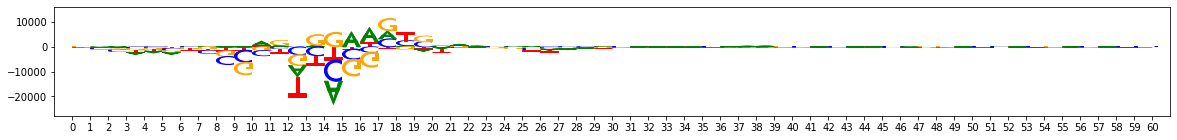

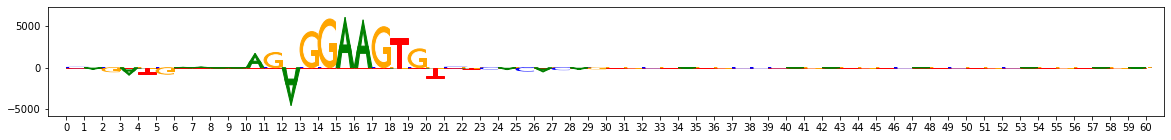

['chr8' 99640513 99641513]


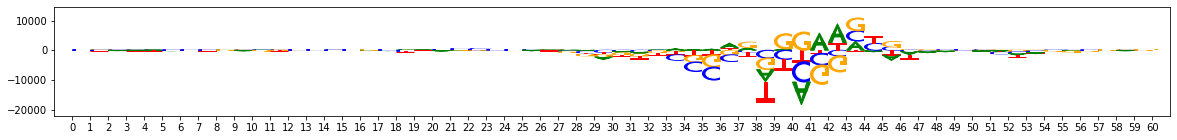

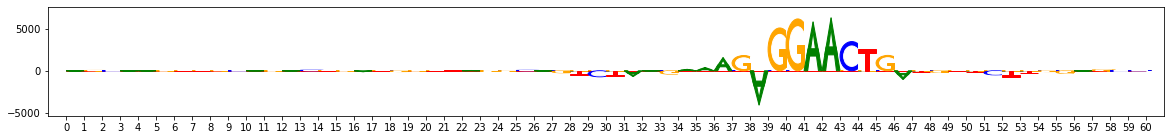

['chr1' 25031843 25032843]


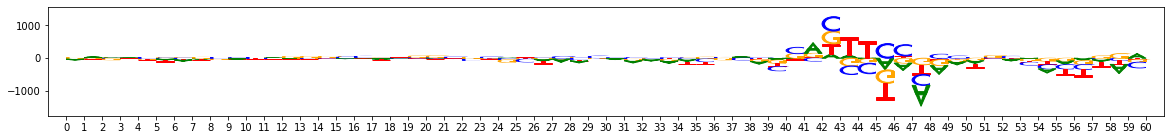

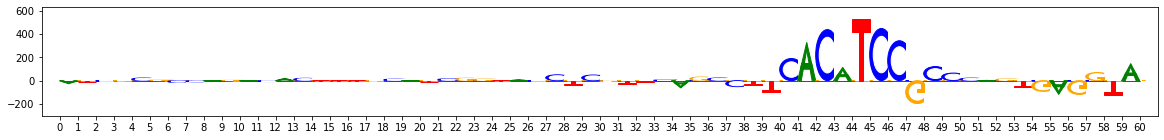

['chr8' 129546479 129547479]


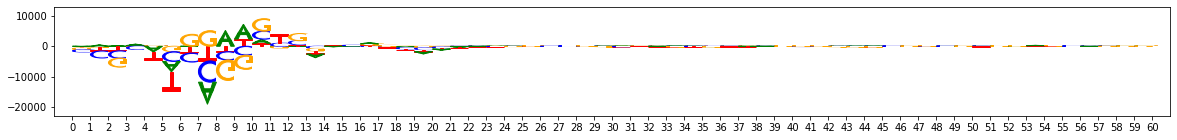

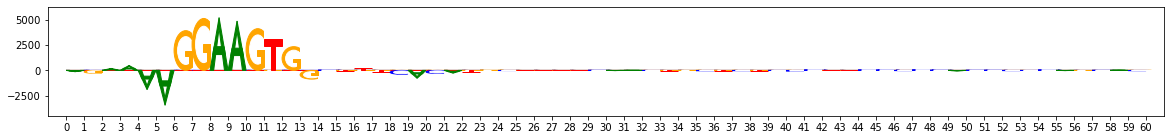

['chr1' 116225653 116226653]


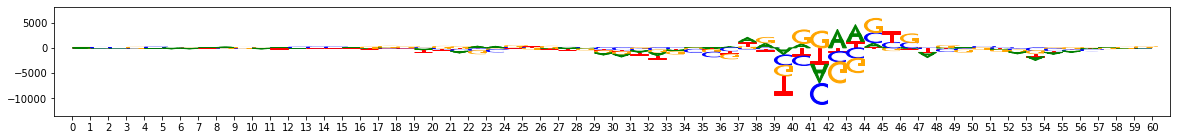

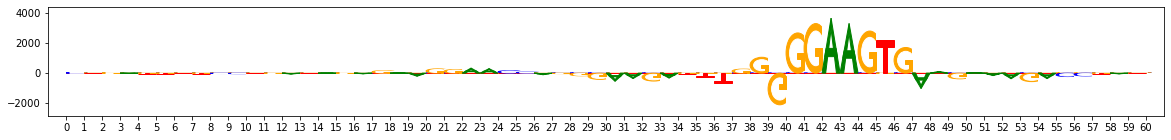

In [10]:
# Plot a few input gradients
num_to_plot = 5
rand_inds = np.random.choice(len(input_grads), size=num_to_plot, replace=False)
center_slice = slice((input_length // 2) - 30, (input_length // 2) + 30)
for i in rand_inds:
    print(peak_coords[i])
    viz_sequence.plot_weights(input_grads[i][center_slice])
    viz_sequence.plot_weights((input_grads[i] * input_seqs[i])[center_slice])

### Assess similarity of input gradient explanations
How similar are the input gradient "explanations" across different examples?

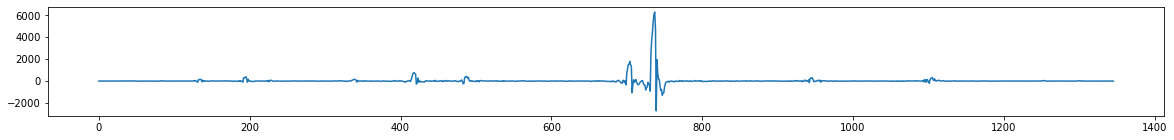

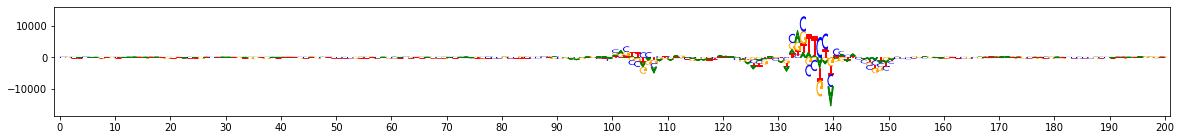

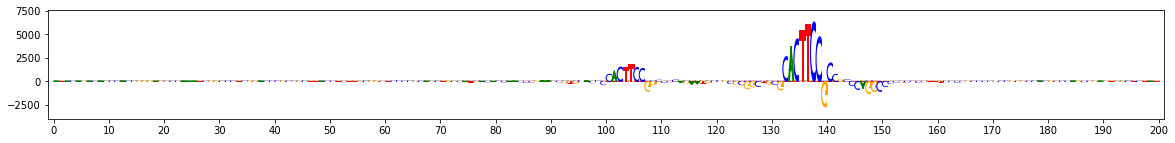

In [12]:
i = 2
plt.figure(figsize=(20, 2))
plt.plot(np.sum(input_grads[i] * input_seqs[i], axis=1))
viz_sequence.plot_weights(input_grads[i][600:800], subticks_frequency=10)
viz_sequence.plot_weights((input_grads[i] * input_seqs[i])[600:800], subticks_frequency=10)

In [36]:
def find_seqlets(grad, seqlet_size=10, thresh=0.7):
    """
    Finds seqlets by picking intervals centered at peaks. Peaks are centered
    at the mode, or anything at least `thresh` the size of the mode. Seqlets
    will not overlap. `seq` is L x 4 array.
    Returns a list of peak centers.
    Note: the gradients here are supposed to be multipled by the sequence.
    """
    heights = np.sum(grad, axis=1)
    mode = np.max(heights)
    
    # All locations where peaks could be centered
    peak_centers = np.where(heights > (thresh * mode))[0]
    
    # Sort peak centers in decreasing order of height
    inds = np.flip(np.argsort(heights[peak_centers]))
    peak_centers = peak_centers[inds]
    # Traverse the list, adding non-overlapping intervals to the list
    half_size = seqlet_size // 2
    final_peak_centers = []
    for center in peak_centers:
        if center < 0:
            # This center has been invalidated (i.e. lies within a
            # previously found interval)
            continue
        left = center - half_size
        right = left + seqlet_size
        final_peak_centers.append(center)
        # Invalidate all centers that lie within this interval
        peak_centers[(peak_centers >= left) & (peak_centers < right)] = -1
    return final_peak_centers

In [14]:
def window_similarities(seq_1, seq_2):
    """
    Takes two windows (W x 4 arrays) and computes a similarity between them,
    using a continuous Jaccard metric.
    """
    ab_1, ab_2 = np.abs(seq_1), np.abs(seq_2)
    inter = np.minimum(ab_1, ab_2) * np.sign(seq_1) * np.sign(seq_2)
    union = np.maximum(ab_1, ab_2)
    cont_jaccard = np.sum(inter, axis=1) / np.sum(union, axis=1)
    return np.sum(cont_jaccard)

In [15]:
def max_seqlet_similarity(seq_1, seq_2, window_size=8):
    """
    Takes two seqlets (S x 4 arrays) and computes the maximum similarity over
    all possible pairwise windows. Returns the starting indices of the best window
    for each sequence, and the resulting score.
    """
    seq_len = seq_1.shape[0]
    best_window_1, best_window_2, best_score = None, None, -float("inf")
    for i in range(0, seq_len - window_size + 1):
        for j in range(0, seq_len - window_size + 1):
            window_score = window_similarities(seq_1[i : i + window_size], seq_2[j : j + window_size])
            if window_score > best_score:
                best_window_1, best_window_2, best_score = i, j, window_score
    return best_window_1, best_window_2, best_score

In [37]:
# Extract out all seqlets
hyp_seqlets, act_seqlets = [], []
actual = []
seqlet_size, thresh = 20, 0.5
for i in tqdm.notebook.trange(len(input_grads)):
    centers = find_seqlets(input_grads[i] * input_seqs[i], seqlet_size=seqlet_size, thresh=0.5)
    seqlet_slices = [slice(center - (seqlet_size // 2), center + (seqlet_size // 2)) for center in centers]
    hyp_seqlets.extend([input_grads[i][slc] for slc in seqlet_slices])
    act_seqlets.extend([input_grads[i][slc] * input_seqs[i][slc] for slc in seqlet_slices])
hyp_seqlets = np.stack(hyp_seqlets, axis=0)
act_seqlets = np.stack(act_seqlets, axis=0)
num_seqlets = len(hyp_seqlets)
print("%d seqlets found over %d sequences" % (num_seqlets, len(input_grads)))


10188 seqlets found over 6516 sequences


Seqlet 6880


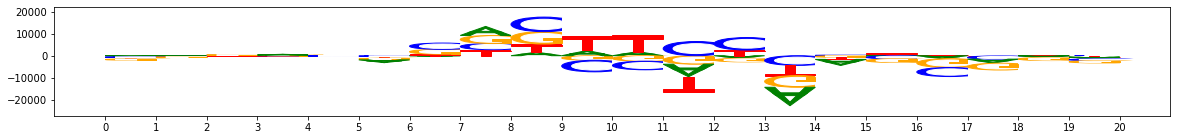

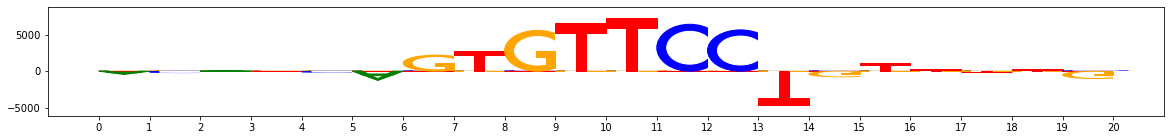

Seqlet 8306


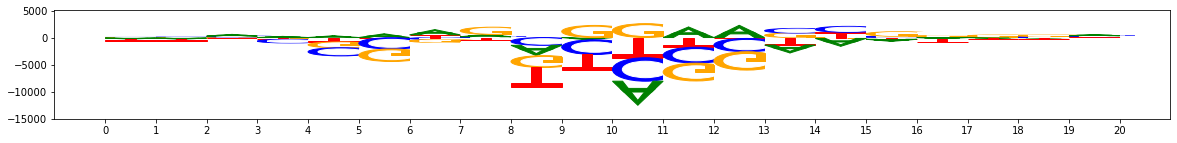

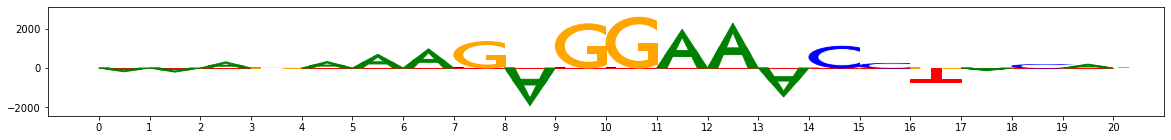

Seqlet 4756


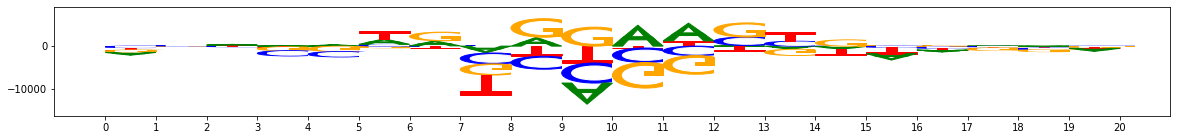

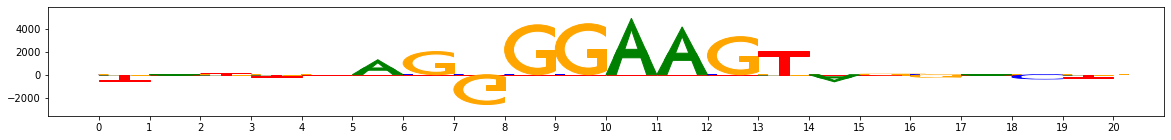

Seqlet 157


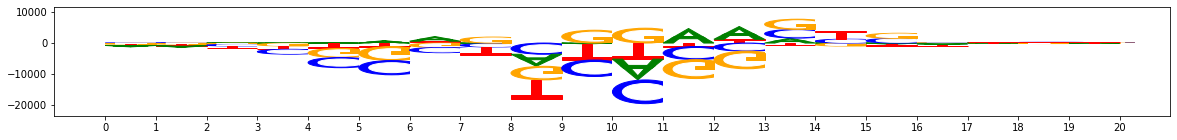

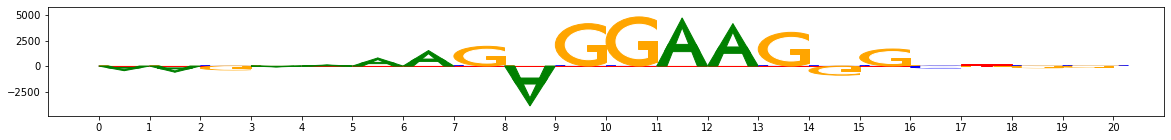

Seqlet 2568


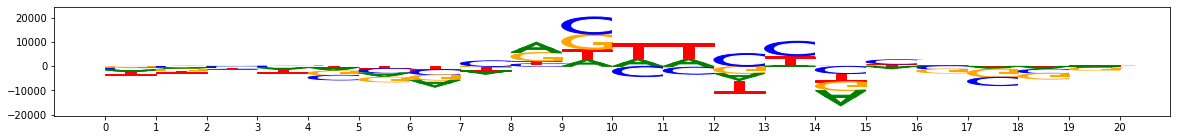

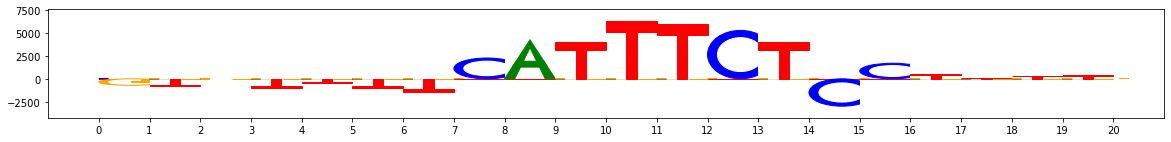

In [41]:
# Plot a few seqlets
num_to_plot = 5
rand_inds = np.random.choice(len(hyp_seqlets), size=num_to_plot, replace=False)
for i in rand_inds:
    print("Seqlet %d" % i)
    viz_sequence.plot_weights(hyp_seqlets[i])
    viz_sequence.plot_weights(act_seqlets[i])

In [76]:
# Compute similarity matrix
sample_size = 1000
sample_inds = np.random.choice(len(hyp_seqlets), size=sample_size, replace=False)
sim_matrix = np.empty((sample_size, sample_size))
np.fill_diagonal(sim_matrix, 0)
for i in tqdm.notebook.trange(sample_size):
    for j in range(i, sample_size):
        sim = max_seqlet_similarity(hyp_seqlets[sample_inds[i]], hyp_seqlets[sample_inds[j]], window_size=20)
        sim_matrix[i, j] = sim[2]
        sim_matrix[j, i] = sim[2]

# Turn all negatives into 0, for clustering
sim_matrix[sim_matrix < 0] = 0

In [77]:
# Perform Louvain clustering to identify clusters
louvain = skn.clustering.Louvain()
cluster_labels = louvain.fit_transform(sim_matrix)
np.unique(cluster_labels, return_counts=True)

(array([0, 1, 2]), array([446, 439, 115]))

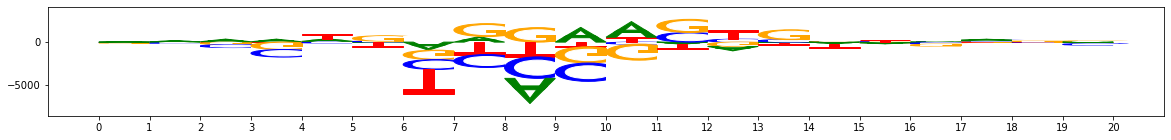

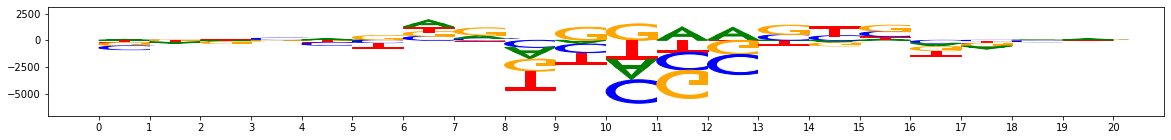

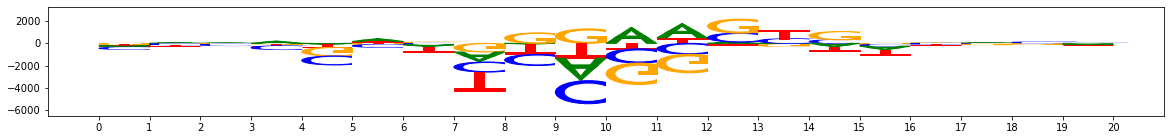

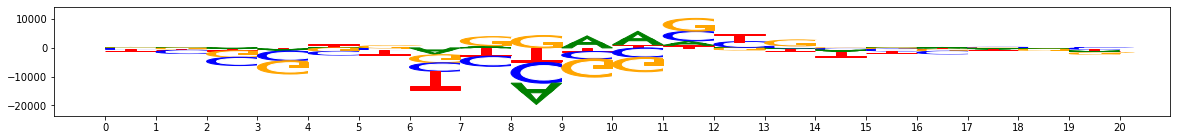

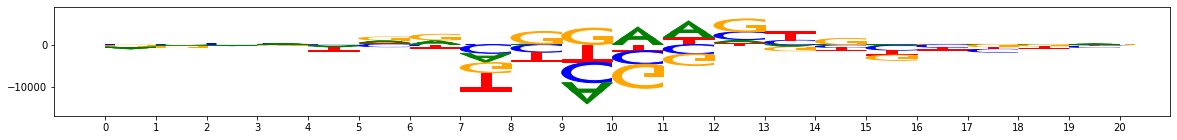

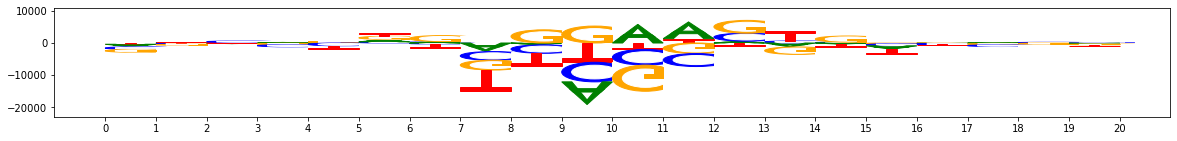

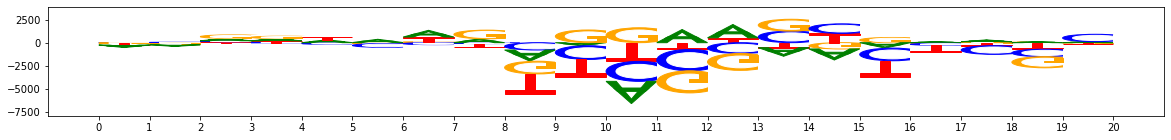

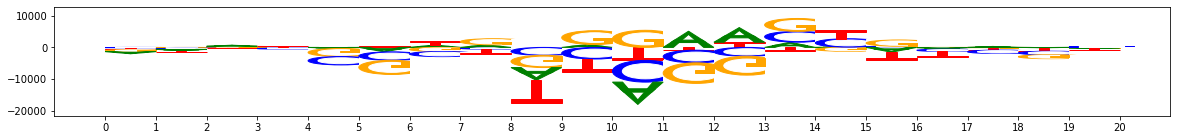

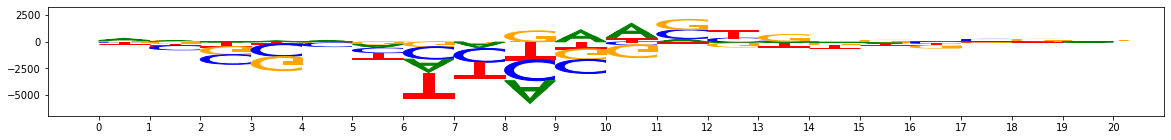

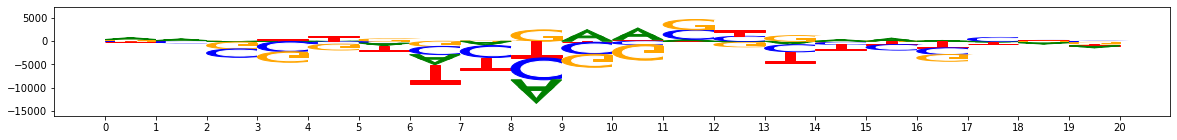

In [81]:
cluster = np.where(cluster_labels == 0)[0]
inds = np.random.choice(len(cluster), size=10, replace=False)
for i in inds:
    viz_sequence.plot_weights(hyp_seqlets[sample_inds[cluster[i]]])